# **RNN 실습 세션 과제**
---
- 출제자 : 김서진 이성균
- 기한 : 2023/09/05 23:59
- 기수/이름 : 윤형진

**Part 1, Part 2의 Task** : <br>
**n_learn개의 앞 단어를 보고, 다음에 나올 한 개의 단어를 예측하기**
<br>
Part 3에 문제가 있습니다. 문제#)으로 표시된 부분을 채워주시면 됩니다.


## Part 1. Pytorch tutorial for RNN
- 개인 공부를 위한 부분으로 별도로 빈칸을 채우는 부분은 없습니다.
- hyperparameter를 조절해보면서 간단한 RNN의 구조를 공부해보세요!
- 출처 : https://justkode.kr/deep-learning/pytorch-rnn/

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# 한 번 코드를 돌린 후, 자유롭게 sentences를 구성해보세요!
sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float

Word processing

In [5]:
word_list = list(set(" ".join(sentences).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)
n_class

9

모델 "TextRNN" 만들기 - 1) parameter 설정 <br>
- `input_size`: Input의 사이즈에 해당 하는 수를 입력하면 됩니다. <br>
- `hidden_size`: 은닉층의 사이즈에 해당 하는 수를 입력하면 됩니다. <br>
- `num_layers`: RNN의 은닉층 레이어 갯수를 나타냅니다. 기본 값은 1입니다. <br>
- `nonlinearity`: 비선형 활성화 함수를 선택합니다. tanh, relu중 하나를 선택 가능하며, 기본 값은 tanh입니다. <br>
- `bias`: 바이어스 값 활성화 여부를 선택합니다. 기본 값은 True 입니다. <br>
- `batch_first`: True일 시, Output 값의 사이즈는 (batch, seq, feature) 가 됩니다. 기본 값은 False 입니다. <br>
- `dropout`: 드롭아웃 비율을 설정 합니다. 기본 값은 0입니다. <br>
- `bidirectional`: True일 시, 양방향 RNN이 됩니다. 기본 값은 False 입니다.

아래 숫자는 학습시켜주는 데이터 'sentences'와 각자의 기호에 따라 자유롭게 조절해보세요.

In [6]:
batch_size = len(sentences)
n_step = 2  # 학습 하려고 하는 문장의 길이에서 1을 빼준 값. 자유롭게 구성한 sentences에 맞춰서 설정해주세요!
n_learn = 2  # 'sentences'에 따라, 앞의 몇 단어를 보고 다음 단어를 예측할 것인지 자유롭게 조절해보세요!
n_hidden = 6  # 은닉층 사이즈 : 자유롭게 조절해보세요!
epochs = 1000 # training 시 반복 횟수 : 자유롭게 조절해보세요!

batch 생성하기

In [7]:
def make_batch(sentences):
  input_batch = []
  target_batch = []

  for sen in sentences:
    word = sen.split()
    input = [word_dict[n] for n in word[:-1]]
    target = word_dict[word[-1]]

    input_batch.append(np.eye(n_class)[input])  # One-Hot Encoding -> 각 고유 단어의 인덱스에 해당하는 identity matrix만을 반환하여 원핫인코딩
    target_batch.append(target)

  return input_batch, target_batch

# batch 만들어주기
input_batch, target_batch = make_batch(sentences)
input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)

<ipython-input-7-7bf93494bd78>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)


2) 모델 구축

In [8]:
class TextRNN(nn.Module):
  def __init__(self):
    super(TextRNN, self).__init__()

    self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.3) # ouput size == (batch_size, n_hidden)
    self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype)) # slef.W == Weight Vector, output을 (batch_size, n_class)로 바꿈 (행렬곱)
    self.b = nn.Parameter(torch.randn([n_class]).type(dtype)) # self.b == Bias Vector, (batch_size, n_class)로 바뀐 행렬에 batch_size번 만큼 bias(상수항) 더해짐
    self.Softmax = nn.Softmax(dim=1) # batch_size의 수만큼 있는 logit을 각 logit별로 확률로 normalize

  def forward(self, hidden, X):
    X = X.transpose(0, 1)
    outputs, hidden = self.rnn(X, hidden)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
    return model

Training

In [9]:
model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
  hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
  output = model(hidden, input_batch)
  loss = criterion(output, target_batch)

  if (epoch + 1) % 100 == 0:
    print('Epoch:', '%04d' % (epoch + 1), '/ cost =', '{:.6f}'.format(loss))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0100 / cost = 0.378456
Epoch: 0200 / cost = 0.046448
Epoch: 0300 / cost = 0.017647
Epoch: 0400 / cost = 0.010008
Epoch: 0500 / cost = 0.006626
Epoch: 0600 / cost = 0.004772
Epoch: 0700 / cost = 0.003626
Epoch: 0800 / cost = 0.002860
Epoch: 0900 / cost = 0.002319
Epoch: 1000 / cost = 0.001921


training 확인

In [10]:
input = [sen.split()[:n_learn] for sen in sentences]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]

result = [number_dict[n.item()] for n in predict.squeeze()]

for idx, a in enumerate(input):
    b = result[idx]
    print(f"{a} -> {b}")

['i', 'like'] -> dog
['i', 'love'] -> coffee
['i', 'hate'] -> milk
['you', 'like'] -> cat
['you', 'love'] -> milk
['you', 'hate'] -> coffee


## Part 2. Pytorch tutorial for LSTM
- 개인 공부를 위한 부분으로 별도로 빈칸을 채우는 부분은 없습니다.
- hyperparameter를 조절해보면서 간단한 LSTM의 구조를 공부해보세요!
- 출처 : https://justkode.kr/deep-learning/pytorch-rnn/

위와 상황이 똑같고, 모델 "TextLSTM" 구성

In [11]:
class TextLSTM(nn.Module):
  def __init__(self):
    super(TextLSTM, self).__init__()

    self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
    self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
    self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
    self.Softmax = nn.Softmax(dim=1)

  def forward(self, hidden_and_cell, X):
    X = X.transpose(0, 1)
    outputs, hidden = self.lstm(X, hidden_and_cell)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
    return model

Training

In [12]:
model = TextLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs): # epoch 수도 자유롭게 조절해보세요!
  hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
  cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
  output = model((hidden, cell), input_batch)
  loss = criterion(output, target_batch)

  if (epoch + 1) % 100 == 0:
    print('Epoch:', '%04d' % (epoch + 1), '/ cost =', '{:.6f}'.format(loss))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0100 / cost = 0.094965
Epoch: 0200 / cost = 0.017409
Epoch: 0300 / cost = 0.008190
Epoch: 0400 / cost = 0.004959
Epoch: 0500 / cost = 0.003400
Epoch: 0600 / cost = 0.002506
Epoch: 0700 / cost = 0.001938
Epoch: 0800 / cost = 0.001550
Epoch: 0900 / cost = 0.001272
Epoch: 1000 / cost = 0.001064


Training 확인

In [13]:
input = [sen.split()[:n_learn] for sen in sentences]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
# RNN과 다른 부분 - Cell state도 설정해주어야 합니다.
cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model((hidden, cell), input_batch).data.max(1, keepdim=True)[1]

result = [number_dict[n.item()] for n in predict.squeeze()]

for idx, a in enumerate(input):
    b = result[idx]
    print(f"{a} -> {b}")

['i', 'like'] -> dog
['i', 'love'] -> coffee
['i', 'hate'] -> milk
['you', 'like'] -> cat
['you', 'love'] -> milk
['you', 'hate'] -> coffee


## Part 3. Application : CNN과 GRU를 활용한 Video classifier 만들기
- known as "CNN-RNN Architecture"
- 본 코드는 tensorflow 및 keras를 기반으로 하며, UCF101 데이터를 활용합니다.
- UCF101 dataset는 유튜브에서 추출된, 사람의 행동 101종류에 대한 영상 총 13320개로 구성된 데이터셋입니다. 데이터셋에 대한 구체적인 설명 : https://www.crcv.ucf.edu/data/UCF101.php
- 데이터셋 사이트 : https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/
- CNN의 원리, RNN(특히 GRU)의 원리 및 tensorflow, keras의 활용법을 종합적으로 공부해보시길 바랍니다.
- 출처 : https://keras.io/examples/vision/video_classification/

### (참고용) 400개 kinetics로 UCF101 데이터셋 살펴보기(실행 안해도 됨)
출처 : https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub?hl=ko

모듈과 메타데이터 불러오기(30초 내외 소요)

In [22]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [23]:
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

`list_ucf_video` : UCF101 데이터셋에 있는 파일명을 리스트로 반환

In [24]:
# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos(): # Lists videos available in UCF101 dataset
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

UCF101에 맞는 400개의 kinetics label 불러오기

In [25]:
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


UCF101 데이터셋 파일명들을 리스트 형태로 확인

In [26]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()

categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories. \n" % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))

Found 13320 videos in 101 categories. 

ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking            

### **1) UCF101 dataset & train/test split**
**실행 전, 최대한 많은 RAM 용량을 확보하기 위해 런타임을 해제 후 다시 실행해주세요!!!** <br>
kaggle에서 데이터를 다운받겠습니다. 이미 subsampling되어 생성된 데이터리스트가 있어서, 그 리스트에 맞게끔 train data와 test data를 구성합니다. <br>
이때 "n"은 추후 분류하고자 하는 행동 범주 개수입니다.

In [27]:
!pip install kaggle --upgrade

먼저 Kaggle 홈페이지에서 본인의 API Token을 json 파일로 다운받아서 코랩에 업로드해야 합니다.<br>
**1) (Kaggle 회원가입을 한 후) 본인 계정 설정 홈페이지의 'Account'로 들어갑니다.**
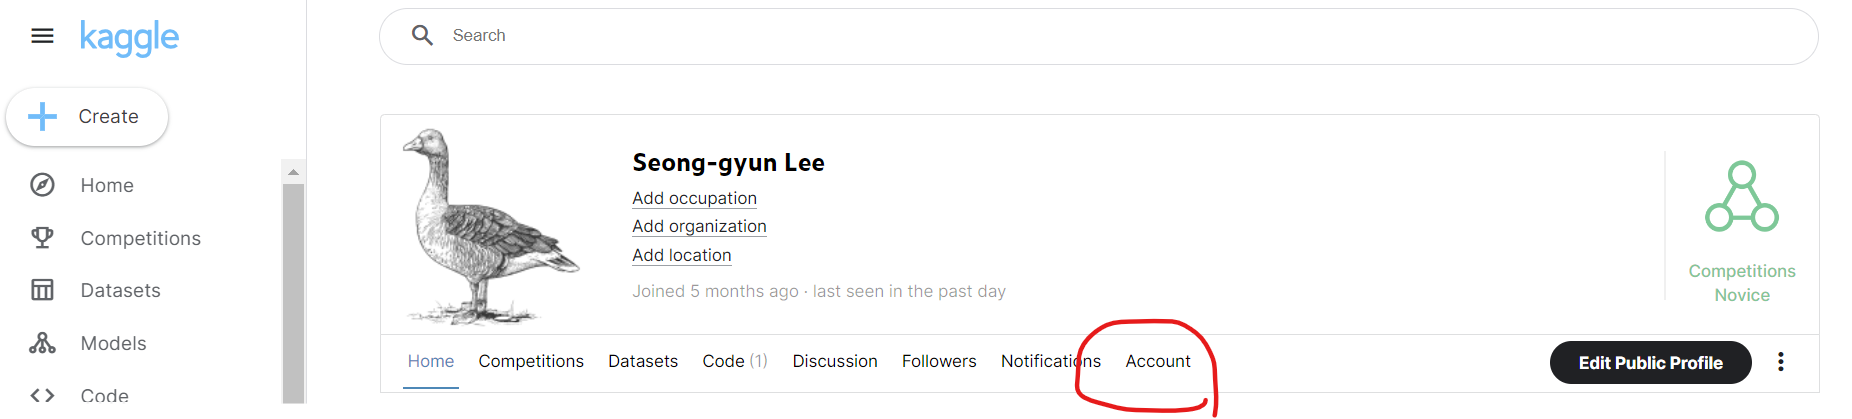

**2) 'Create New Token'을 통해 생성되는 kaggle.json 파일을 다운로드합니다.**
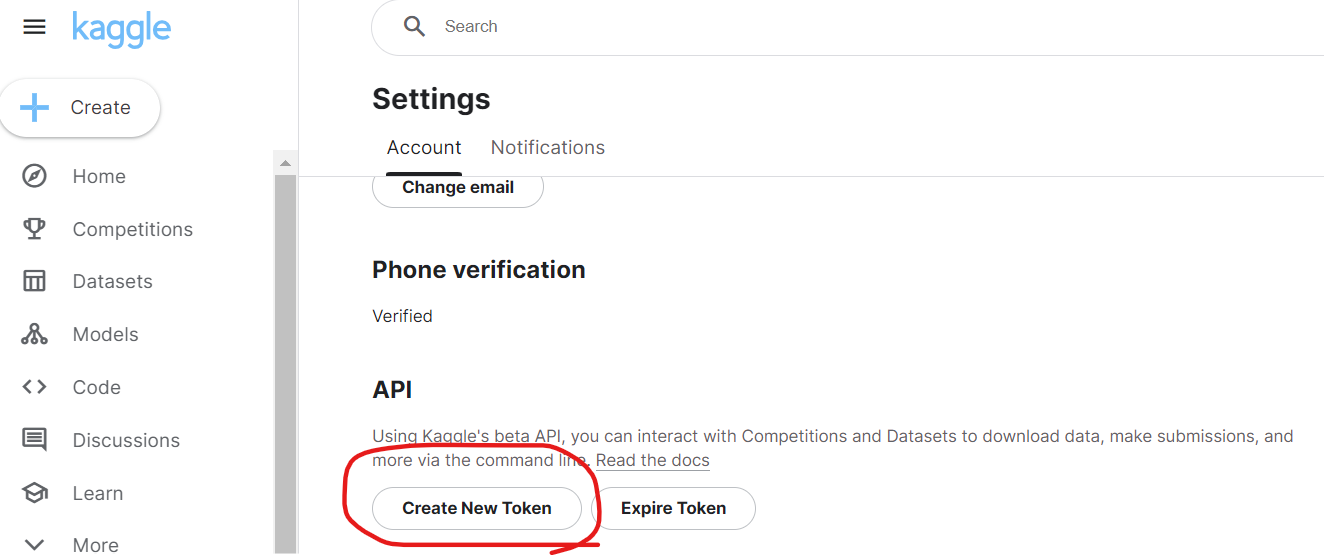

**3) 아래에서 kaggle.json 파일을 업로드합니다.**

In [28]:
from google.colab import files
files.upload()
# 파일 선택 버튼 클릭 후 kaggle.json 파일 업로드

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"yoonhyungjin","key":"179722c29c8193638dbc1fd28f2d853a"}'}

코랩 내부에서 kaggle.json 파일 위치 변경

In [29]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

아래 실행 후 kaggle.json이 뜨면 잘 설정된 것입니다.

In [11]:
!ls -1ha kaggle.json

kaggle.json


이제 kaggle에서 데이터를 다운받겠습니다. google drive를 마운트하지 않았으므로 google drive의 용량을 쓰지 않으며, 다운받고 압축을 해제한 후에 런타임 연결을 해제하면 데이터가 삭제되므로 주의해야 합니다.<br>
압축파일 다운받는데에 컴퓨팅 환경에 따라 1분~5분이 소요됩니다.

In [31]:
!kaggle datasets download -d pevogam/ucf101

100% 6.47G/6.49G [01:04<00:00, 106MB/s]
100% 6.49G/6.49G [01:04<00:00, 108MB/s]


만약 401 - Unauthorized가 뜨면, 런타임 연결을 해제한 후 다시 실행시키거나, API Token을 새로 다운받아서 다시 json 파일을 업로드해주고 다시 실행해보세요. <br>
압축파일을 푸는 데에 약 3분이 소요됩니다.

In [32]:
# 압축 풀기
!unzip ucf101.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c02.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c03.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c04.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c05.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c06.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g02_c01.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g02_c02.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g02_c03.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g02_c04.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g03_c01.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g03_c02.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g03_c03.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g03_c04.avi  
  inflating: UCF101/UCF-101/

Data import & Metadata loading

In [33]:
from imutils import paths
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import cv2
import os

필요한 함수 정의

In [34]:
def extract_tag(video_path):
    return video_path.split("/")[0]

def separate_video_name(video_name):
    return video_name.split("/")[1]

def rectify_video_name(video_name):
    return video_name.split(" ")[0]

이미 subsampling 되어있는 trainlist01.txt와 testlist01.txt에 따라 비디오 데이터를 분류하고(7:3 비율), 각 데이터의 비디오 파일명을 csv로 만들겠습니다. <br>
**아래 각종 경로 지정 부분은 Colab을 기준으로 작성된 것으로, 컴퓨팅 환경에 따라 달라져야 할 수 있습니다. 따라서 Colab에서 구동하는 것을 권장드립니다.**

In [35]:
# Open the .txt file which have names of training videos
f = open("/content/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# Create a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]
train.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1


In [36]:
# Open the .txt file which have names of test videos
with open("/content/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/testlist01.txt", "r") as f:
    temp = f.read()
videos = temp.split("\n")

# Create a dataframe having video names
test = pd.DataFrame()
test["video_name"] = videos
test = test[:-1]
test.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi


In [37]:
train["tag"] = train["video_name"].apply(extract_tag)
train["video_name"] = train["video_name"].apply(separate_video_name)
train.head()

,video_name,tag
0,v_ApplyEyeMakeup_g08_c01.avi 1,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c02.avi 1,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c03.avi 1,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c04.avi 1,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c05.avi 1,ApplyEyeMakeup


In [38]:
train["video_name"] = train["video_name"].apply(rectify_video_name)
train.head()

,video_name,tag
0,v_ApplyEyeMakeup_g08_c01.avi,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c02.avi,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c03.avi,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c04.avi,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c05.avi,ApplyEyeMakeup


In [39]:
test["tag"] = test["video_name"].apply(extract_tag)
test["video_name"] = test["video_name"].apply(separate_video_name)
test.head()

,video_name,tag
0,v_ApplyEyeMakeup_g01_c01.avi,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g01_c02.avi,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g01_c03.avi,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g01_c04.avi,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g01_c05.avi,ApplyEyeMakeup


본 과제에서는 비디오 중 가장 많은 영상들이 있는 상위 n=5개의 범주에 대한 classifier를 만들어보겠습니다(이것에 맞춰서 trainlist01.txt와 testlist01.txt가 구성됨)

In [40]:
n = 5 # 가장 많은 영상이 있는 범주의 개수(n=10이면 1등~10등으로 개수 많은 범주의 영상 추출)
topNActs = train["tag"].value_counts().nlargest(n).reset_index()["index"].tolist()
train_new = train[train["tag"].isin(topNActs)]
test_new = test[test["tag"].isin(topNActs)]
train_new.shape, test_new.shape

((594, 2), (218, 2))

`move_videos` : train data, test data를 폴더로 빼주는 함수

In [41]:
def move_videos(df, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for j in tqdm(range(n)):
      tag = df["tag"].unique()[j]
      for i in tqdm(range(df.shape[0])):
        videoFile = df['video_name'][i].split("/")[-1]
        if df["tag"][i] == tag:
          videoPath = os.path.join("/content/UCF101/UCF-101", tag, videoFile)
          shutil.copy2(videoPath, output_dir)
    print()
    print(f"Total videos: {len(os.listdir(output_dir))}")

In [42]:
train_new = train_new.reset_index(drop=True)
test_new = test_new.reset_index(drop=True)

data split

In [43]:
move_videos(train_new, "/content/UCF101TrainTestSplits-RecognitionTask/Train")

100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Total videos: 594


In [44]:
move_videos(test_new, "/content/UCF101TrainTestSplits-RecognitionTask/Test")

100%|██████████| 218/218 [00:00<00:00, 7100.71it/s]

100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


Total videos: 218


파일명은 csv로 따로 저장

In [45]:
train_new.to_csv("/content/UCF101TrainTestSplits-RecognitionTask/UCF101_train.csv", index=False)
test_new.to_csv("/content/UCF101TrainTestSplits-RecognitionTask/UCF101_test.csv", index=False)

In [46]:
train_new

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
589,v_ShavingBeard_g25_c02.avi,ShavingBeard
590,v_ShavingBeard_g25_c03.avi,ShavingBeard
591,v_ShavingBeard_g25_c04.avi,ShavingBeard
592,v_ShavingBeard_g25_c05.avi,ShavingBeard


### **2) 모델 구축 준비**

In [47]:
!pip install git+https://github.com/tensorflow/docs
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-c3qwa4za
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-c3qwa4za
  Resolved https://github.com/tensorflow/docs to commit eae9a407fd74f8caf7715134beddabc6fffdf8d7
  Preparing metadata (setup.py) ... done


#### Dataset import
먼저 training과 test에 필요한 비디오 파일과 짝지어진 label을 편리하게 업로드하기 위해, label로 정리된 csv파일을 불러옵니다. <br>
**문제1) UCF101_N_train.csv와 UCF101_N_test.csv 두 개의 파일을 각각 `train_df`과 `test_df`라는 개체로 저장해주세요.** <br>
**문제2) 각 파일이 잘 불러와졌는지, `.sample` 메소드를 활용해서 확인해주세요.**

In [48]:
train_df = pd.read_csv("/content/UCF101TrainTestSplits-RecognitionTask/UCF101_train.csv")
test_df = pd.read_csv("/content/UCF101TrainTestSplits-RecognitionTask/UCF101_test.csv")

check_train = train_df.sample(n = 20, random_state = 777)
check_test = test_df.sample(n = 20, random_state = 777)

check_train, check_test

(                      video_name            tag
 580   v_ShavingBeard_g23_c07.avi   ShavingBeard
 224   v_PlayingCello_g24_c01.avi   PlayingCello
 561   v_ShavingBeard_g21_c02.avi   ShavingBeard
 389          v_Punch_g13_c01.avi          Punch
 261  v_PlayingGuitar_g11_c06.avi  PlayingGuitar
 96     v_CricketShot_g22_c05.avi    CricketShot
 56     v_CricketShot_g16_c01.avi    CricketShot
 241  v_PlayingGuitar_g08_c04.avi  PlayingGuitar
 438          v_Punch_g20_c02.avi          Punch
 489   v_ShavingBeard_g09_c07.avi   ShavingBeard
 508   v_ShavingBeard_g13_c02.avi   ShavingBeard
 9      v_CricketShot_g09_c03.avi    CricketShot
 147   v_PlayingCello_g12_c03.avi   PlayingCello
 334  v_PlayingGuitar_g22_c03.avi  PlayingGuitar
 427          v_Punch_g18_c05.avi          Punch
 101    v_CricketShot_g23_c03.avi    CricketShot
 527   v_ShavingBeard_g16_c02.avi   ShavingBeard
 382          v_Punch_g12_c01.avi          Punch
 303  v_PlayingGuitar_g17_c06.avi  PlayingGuitar
 97     v_CricketSho

In [49]:
del check_test
del check_train

In [50]:
# 결과로 ['CricketShot', 'PlayingCello', 'PlayingGuitar', 'Punch', 'ShavingBeard'] 가 나와야 합니다.
train_df['tag'].unique()

array(['CricketShot', 'PlayingCello', 'PlayingGuitar', 'Punch',
       'ShavingBeard'], dtype=object)

#### Hyperparameter 정의하기

In [51]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 15  #조절 가능

MAX_SEQ_LENGTH = 40 #조절 가능
NUM_FEATURES = 2048

### **3) CNN 원리 활용**
2D 사진이 아닌, 3D 비디오를 어떻게 ConvNet으로 넣을 것인가(feed to a network)가 항상 문제가 됩니다. 비디오마다 프레임의 크기가 다르기 때문에 일정한 3D tensor로 넣기가 어렵기 때문이죠. 그래서 이를 해결하기 위해, **"비디오들 각각의 프레임 수의 최댓값"**으로 ConvNet의 비디오 프레임 크기를 지정합니다. <br>
- 1단계 : 비디오마다 프레임 크기를 인식한다.
- 2단계 : 프레임 수의 최댓값이 감지될 때까지 계속 프레임 크기를 인식한다.
- 3단계 : 프레임 수의 최댓값보다 적은 수의 프레임을 갖는 비디오의 경우, 나머지는 zero-padding으로 채운다. <br>

** 제안된 여러 방법 : https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5 <br>

물론 이번 과제에서 다루는 UCF101 데이터셋은 프레임 크기의 변동성이 크지 않습니다. `OpenCV` 패키지의 `VideoCapture()` 함수를 이용해서 비디오의 프레임 크기를 인식해보겠습니다.
- `fetch_ucf_video` : UCF101 데이터셋에 있는 비디오 파일들을 OS에 임시로 저장해두고, 그 경로를 반환

**문제3) 빈칸을 채워주세요.** <br>
**문제4-1,2,3) 아래의 함수 `load_video` 는 feature extraction에 있어서 아주 중요한 함수입니다. 주석의 물음표 부분에 그 줄의 코드가 무엇을 하는 코드인지 설명을 간단히 적어주세요.**

In [52]:
def fetch_ucf_video(video): # Fetchs a video and cache into local filesystem
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin("https://www.crcv.ucf.edu/data-sets/ucf101/", video)  ## 문제3 ##
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path) ## 문제4-1) ??????
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame) ## 문제4-2) ??????
            frame = cv2.resize(frame, resize) ## 문제4-3) ??????
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

문제4 답안 <br><br/>
4-1 : cv2.VideoCapture() 클래스에서 인스턴스를 초기화하여 주어진 디렉토리 경로의 프레임 수 읽기 <br><br/>
4-2 : ret == True라면, cv2.VideoCapture()를 통해 얻은 frame 크기만큼 중앙지점에서 일정한 영역의 사각형으로 자르기.<br><br/>
4-3 : cv2.resize()를 통해 원하는 크기로 변경해주기<br><br/>

#### Transfer learning : InceptionV3
비디오의 feature을 뽑아내는 데에 keras의 모듈을 활용하고 InceptionV3이라는 모델을 전이학습해서 활용해보려고 합니다. <br>
InceptionV3 모델 설명 : https://cloud.google.com/tpu/docs/inception-v3-advanced?hl=ko

In [53]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

# generating an instance
feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 0s 0us/step


#### StringLookup
우리가 업로드한 csv 파일의 'tag'는 string이기 때문에, 모델에 넣어주기 전 integer로 바꿔주는 작업이 필요합니다. 이것은 keras의 `StringLookup`이라는 메소드로 수행할 수 있습니다.

In [54]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'PlayingGuitar', 'Punch', 'ShavingBeard']


#### Feature extraction
**문제5) 빈칸에는 위의 "3) CNN 원리 활용" 부분에서 설명한 원리에 따라 Numpy의 어떤 함수가 들어가야 합니다. 빈칸을 채워주세요. (네 개의 빈칸은 같은 함수임)**

In [55]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # Hint 1 : `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # Hint 2 : `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            print(f"<{idx+1}/{len(video_paths)}>")
            print(f"video: {path}")
            print(f"frames: {frames.shape}")
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

실행 : 영상을 한 개씩 처리하는 함수라서 오래 걸립니다. Colab의 **T4 GPU 환경을 권장**합니다. <br>
(Colab CPU 환경에서 1분에 영상 5~7개 정도 처리) <br>
유튜브 5개 보고 오십쇼..

In [56]:
train_data, train_labels = prepare_all_videos(train_df, "/content/UCF101TrainTestSplits-RecognitionTask/Train")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 30ms/step
<479/594>
video: v_ShavingBeard_g08_c03.avi
frames: (1, 102, 224, 224, 3)
1/1 [==============================] - 0s 39ms/step
<480/594>
video: v_ShavingBeard_g08_c04.avi
frames: (1, 155, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
<481/594>
video: v_ShavingBeard_g08_c05.avi
frames: (1, 153, 224, 224, 3)
1/1 [==============================] - 0s 33ms/step
<482/594>
video: v_ShavingBeard_g08_c06.avi
frames: (1, 104, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
<483/594>
video: v_ShavingBeard_g08_c07.avi
frames: (1, 157, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
<484/594>
video: v_ShavingBeard_g09_c01.avi
frames: (1, 160, 224, 224, 3)
1/1 [==============================] - 0s 32ms/step
<485/594>
video: v_ShavingBeard_g09_c02.avi
frames: (1, 133, 224, 224, 3)
1/1 [==============================] - 0s 33ms/step
<486/594>
video: v_ShavingBear

In [57]:
test_data, test_labels = prepare_all_videos(test_df, "/content/UCF101TrainTestSplits-RecognitionTask/Test")

print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 26ms/step
<103/218>
video: v_PlayingGuitar_g02_c04.avi
frames: (1, 200, 224, 224, 3)
1/1 [==============================] - 0s 43ms/step
<104/218>
video: v_PlayingGuitar_g03_c01.avi
frames: (1, 250, 224, 224, 3)
1/1 [==============================] - 0s 44ms/step
<105/218>
video: v_PlayingGuitar_g03_c02.avi
frames: (1, 250, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
<106/218>
video: v_PlayingGuitar_g03_c03.avi
frames: (1, 250, 224, 224, 3)
1/1 [==============================] - 0s 60ms/step
<107/218>
video: v_PlayingGuitar_g03_c04.avi
frames: (1, 250, 224, 224, 3)
1/1 [==============================] - 0s 33ms/step
<108/218>
video: v_PlayingGuitar_g03_c05.avi
frames: (1, 250, 224, 224, 3)
1/1 [==============================] - 0s 28ms/step
<109/218>
video: v_PlayingGuitar_g03_c06.avi
frames: (1, 250, 224, 224, 3)
1/1 [==============================] - 0s 73ms/step
<110/218>
video: v_Play

### **4) RNN 원리 활용 : GRU**
**문제6) 아래의 함수 `get_squence_model` 은 비디오에서 뽑아낸 feature을 GRU layer에 넣어서 결과(n=5개의 행동 범주)를 반환하는 함수입니다. 주석의 물음표 부분에 그 줄의 코드가 무엇을 하는 코드인지 설명을 간단히 적어주세요.** <br>
keras GRU layer 설명 : https://keras.io/api/layers/recurrent_layers/gru/

In [58]:
# Utility for our sequence model.
def get_sequence_model():
    """
    문제 6-1)
    label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
    위 코드로 생성한 label_processor 객체에서 unique label 즉 unique vocabulary를 받는다
    """
    class_vocab = label_processor.get_vocabulary() ### 문제6-1) ?????

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output) ### 문제6-2) ?????
    """
    문제 6-2)
    keras를 이용하여 모델 객체를 생성한다.
    forward 연산을 위한 코드와 이를 종합하여 하나의 객체로 반환하는 코드를 하나의 함수 get_sequence_model() 안에 작성하여, 최종적으로는 get_sequence_model()이 RNN 모델을 반환한다
    keras.layers.GRU(16, return_sequence = True)(frame_features_input, mask=mask_input)
    -> 16개 cell로 이루어진 GRU, 최종 hidden state만이 아닌 전체 hidden state을 다음 GRU로 보냄
    keras.layers.GRU(8)(x)
    -> 8개 cell로 이루어진 GRU, 최종 hidden state만을 마지막 fully connected layer로 보냄
    x = keras.layers.Dense(8, activation="relu")(x)
    -> 8개 노드로 이루어진 fc layer, ReLU 활성화 함수를 이용, 비선형적인 특징을 학습할 수 있게한다
    keras.layers.Dense(len(class_vocab), activation="softmax")(x)
    -> 마지막 fc layer, 유니크한 단어 수 만큼의 출력 노드 수를 가진다. softmax를 이용해 출력노드들의 값을 확률값으로 정규화하여 최종 출력값을 반환한다.
    """

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"\n Test accuracy: {round(accuracy * 100, 5)}%")

    return history, seq_model

### **5) 모델 시행 & 결과 확인**
**문제7) 위의 hyperparameter를 잘 튜닝하여, Test accuracy가 70% 이상이 되도록 해주세요.** <br>
Hint : 주로 조절할 hyperparameter는 `EPOCHS`와 `MAX_SEQ_LENGTH`일 것입니다.

In [59]:
_, sequence_model = run_experiment()

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 1.2819 - accuracy: 0.4265
Epoch 1: val_loss improved from inf to 2.34258, saving model to /tmp/video_classifier
13/13 [==============================] - 15s 243ms/step - loss: 1.2819 - accuracy: 0.4265 - val_loss: 2.3426 - val_accuracy: 0.3073
Epoch 2/15
11/13 [========================>.....] - ETA: 0s - loss: 1.0439 - accuracy: 0.6534
Epoch 2: val_loss improved from 2.34258 to 2.15827, saving model to /tmp/video_classifier
13/13 [==============================] - 0s 33ms/step - loss: 1.0374 - accuracy: 0.6627 - val_loss: 2.1583 - val_accuracy: 0.3408
Epoch 3/15
12/13 [==========================>...] - ETA: 0s - loss: 0.9179 - accuracy: 0.7448
Epoch 3: val_loss did not improve from 2.15827
13/13 [==============================] - 0s 31ms/step - loss: 0.9157 - accuracy: 0.7470 - val_loss: 2.3732 - val_accuracy: 0.3408
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.8476 - accuracy: 0.7831
Epoch 4: 

#### 결과를 편리하게 확인하기 위한 함수 정의
- `prepare_single_video`
- `sequence_prediction`
- `to_gif` : 텐서 프레임을 gif로 변환해서 시각화

In [60]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("/content/UCF101TrainTestSplits-RecognitionTask/Test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=20)
    return embed.embed_file("animation.gif")

#### 분류 결과 확인
`np.random.choice`로 무작위 확인

Test video path: v_CricketShot_g04_c04.avi
1/1 [==============================] - 2s 2s/step
  CricketShot: 58.29%
  Punch: 16.68%
  PlayingCello: 10.94%
  PlayingGuitar:  9.67%
  ShavingBeard:  4.42%



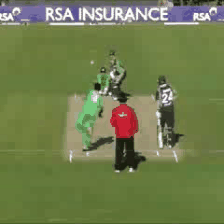

In [61]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

**문제8) 결과를 캡쳐하여 아래에 사진으로 삽입해주세요.** <br>
**결과 예시 :**
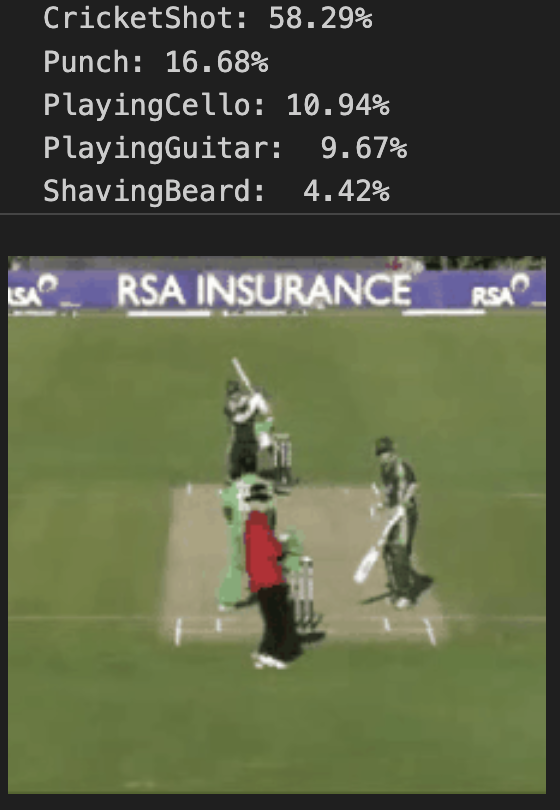


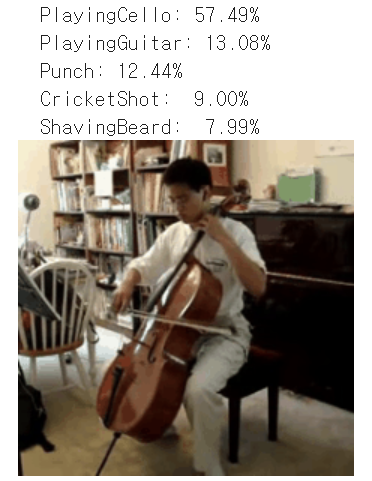

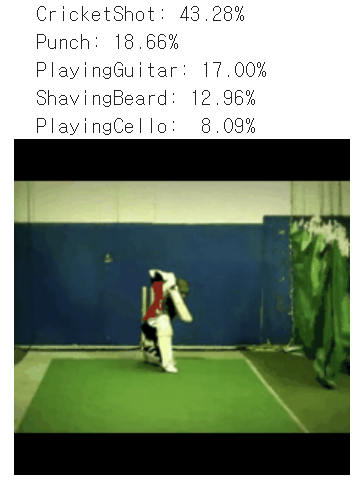

**긴 시간동안 해결하시느라 수고 많으셨습니다!!!**